## Library import

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

! pip install transformers
! pip install --upgrade gensim
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

Mounted at /content/drive
     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 37.0 MB/s 
     |████████████████████████████████| 895 kB 25.9 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 47.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 24.1 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Language processing
import string
import nltk
import re

# System
import sys
path_smt = '/content/drive/MyDrive/dis/'
sys.path.append(path_smt)

# Data preprocessing
from preprocessing import * 
import pandas as pd
np.random.seed(1)
import numpy as np
from sklearn.preprocessing import StandardScaler
from nltk.stem import WordNetLemmatizer
import collections

# Statistical tools
import scipy.stats as stat

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Word2vec
import gensim
import gensim.downloader
from gensim.models import Word2Vec
google_news_vectors = gensim.downloader.load('word2vec-google-news-300')
        
# Clustering
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

# Cluster metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

[==================================================] 100.0% 1662.8/1662.8MB downloaded


# Visualisation of word embeddings

In [ ]:
# Assigning word2vec vectors for each of the selected words
group = google_news_vectors["group"]
children = google_news_vectors["children"]
playing = google_news_vectors["playing"]
house = google_news_vectors["house"]
yard = google_news_vectors["yard"]
kids = google_news_vectors["kids"]
boys = google_news_vectors["boys"]
# List with all vectors
all_wrds = [group, children, playing, house, yard, kids, boys]
vecs_example = np.zeros((len(all_wrds), 300))
for nb, wrd in enumerate(all_wrds):
    vecs_example[nb] = wrd
# PCA
pca = PCA(n_components=2)
pca_example = pca.fit_transform(vecs_example)
# Normalising
normalized = normalize(pca_example, norm='l2')
# Adding some noise for plotting purposes
normalized = normalized + np.random.normal(loc=0, scale = 0.2, size= pca_example.shape)

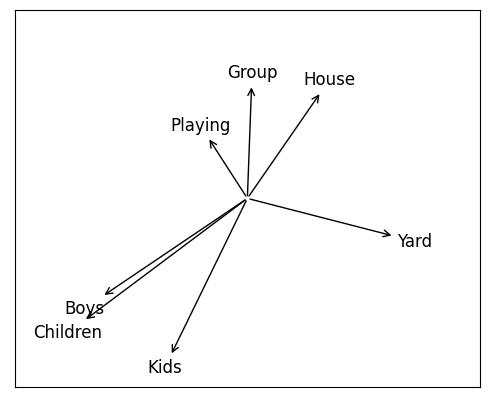

In [ ]:
plt.rcParams['figure.dpi'] = 100
fig = plt.figure(figsize=(6, 5))

ax = fig.add_subplot(111)
ax.set_ylim([-1.3,1.3])
ax.set_xlim([-1.3,1.3])
# Annotations
for nb, wrd in enumerate(["Group", "Children", "Playing", "House", "Yard", "Kids", "Boys"]):
    ax.annotate(s = wrd, xy=(0, 0) , xytext=(normalized[nb][0], normalized[nb][1]), 
                arrowprops=dict(arrowstyle="<-"), ha='right', va='center', size = 12)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
# fig.savefig('circle.pdf', format='pdf') 

## Data import

In [ ]:
dt_raw = pd.read_csv(path_smt+"twitter.txt", encoding='utf-8')
dt_full = dt_raw[["Topic", "Sentiment", "TweetText"]]
dt_names = dt_full.rename(columns = {'TweetText':'sent'})
# Subsample of the dataset for clustering
dt = dt_names.sample(200, random_state = 1, ignore_index=True)

## Preprocessing

In [ ]:
# All words in word2vec
google_lst = google_news_vectors.index_to_key

def lemmatise(dt_long):
    preprocess("sent", dt_long)
    all_words = set(' '.join(dt_long['sent_punct']).split())   
    add_google = all_words.difference(google_lst)
    # Change to the lemmatised version of the word if in dictionary
    new_long = add_words(add_google, dt_long)
    return new_long

# Check if lemmatised word in dictionary
def add_words(absent, dt_long):
    replace_long = dt_long
    for wrd in absent:
        # Lemmatise
        lem = wnl.lemmatize(wrd)
        if lem != wrd:
            if lem in google_news_vectors:
              # If lemmatised version in dictionary, replace the word in the dataset
                replace_long = replace_long.replace({wrd:lem}, regex=True)
    return replace_long

dt = lemmatise(dt)

# Subsetting all words that are absent in word2vec
all_words = set(' '.join(dt['sent_punct']).split())   
add_google = all_words.difference(google_lst)

# Adding unknown words as random vectors
for wrd in add_google:
    google_news_vectors[wrd] = np.random.normal(size = 300)

# Tokenisation as the final step of preprocessing
tokens = dt.apply(lambda row: nltk.word_tokenize(row['sent_punct']), axis=1)

## WMD predictions

In [ ]:
sims_google_raw = np.zeros((len(dt), len(dt)))

# Calculating WMD distance for all pairs of sentences
for i in range(len(dt)):
    for j in range(i):
        if i != j:
            sims_google_raw[i, j] = wmdist(google_news_vectors, tokens[i], tokens[j])

# We only calculated the distance for the upper triangular part of the matrix 
# becuase the final matrix is symmetric            
sims_google_full = np.maximum(sims_google_raw, sims_google_raw.transpose())
# Inverse of the distances
sims_google = 1/(1+sims_google_full)

In [ ]:
# np.save("sims_google.npy", sims_google)

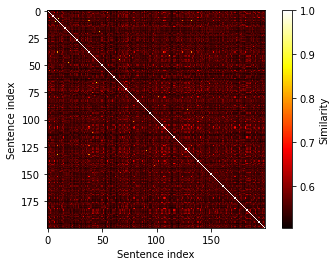

In [ ]:
# Heatmap of similarities
plt.imshow(sims_google, cmap = "hot", interpolation='nearest')
plt.xlabel("Sentence index")
plt.ylabel("Sentence index")
bar = plt.colorbar()
bar.set_label("Similarity")
plt.savefig("sim_matrix.pdf")

# Clustering

In [ ]:
# sims_google = np.load('/content/drive/MyDrive/dis/sims_google.npy')
normal = normalize(sims_google)

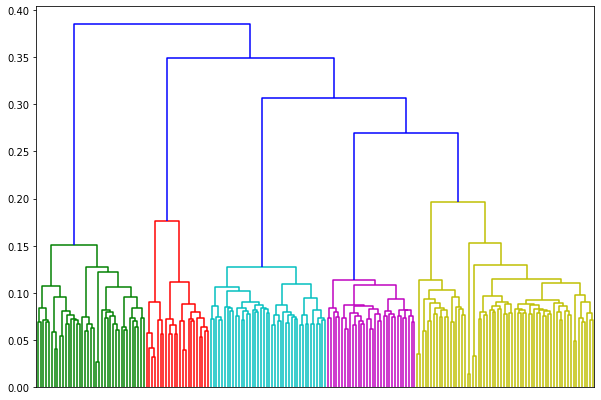

In [ ]:
# Dendrogram
plt.figure(figsize=(10, 7))  
dend = shc.dendrogram(shc.linkage(normal, method='ward'), labels=[""] * 200)
# plt.savefig('dend.pdf',bbox_inches='tight') 

### Cluster silhouette

In [ ]:
# Maximum analysed number of clusters
maxim_cluster = 21
# Minimum analysed number of clusters
minim_cluster = 3
silh = np.zeros(maxim_cluster-minim_cluster)
for i in range(minim_cluster, maxim_cluster):
    cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    clusters = cluster.fit_predict(normal)   
    silh[i-minim_cluster] = silhouette_score(normal, clusters)

## Rand index

In [ ]:
rand = np.zeros((maxim_cluster-minim_cluster-1, 2))
cluster_algorithm = AgglomerativeClustering(n_clusters=minim_cluster, affinity='euclidean', linkage='ward')  
cluster_old = cluster_algorithm.fit_predict(normal)  
for i in range(minim_cluster+1, maxim_cluster):
    cluster_algorithm = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    cluster_new = cluster_algorithm.fit_predict(normal)   
    rand[i-minim_cluster-1, 0] = rand_score(cluster_old, cluster_new)
    rand[i-minim_cluster-1, 1] = adjusted_rand_score(cluster_old, cluster_new)    
    cluster_old = cluster_new

## Within and between cluster sum of squares

In [ ]:
len_sample = normal.shape[0]
within_clusters = np.zeros(maxim_cluster-minim_cluster)
between_clusters = np.zeros(maxim_cluster-minim_cluster)
# Centroid of all datapoints
centroid = np.mean(normal, axis = 0)
# calinski = np.zeros(maxim_cluster-minim_cluster)
for i in range(minim_cluster, maxim_cluster):
    cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    clusters = cluster.fit_predict(normal) 
    # Distance from cluster centroid to datapoint
    sum_squares = np.zeros(i)
    # Distance from cluster centroid to main centroid
    all_dists = np.zeros(i)
    for j in range(i):
      # Subset datapoints from a specific cluster
        sbst = normal[clusters == j]
        # Number of datapoints in cluster
        len_sbst = len(sbst)
        # Centroid of the cluster
        col_mean = np.mean(sbst, axis = 0)
        # Sum is over all datapoints to get the distance for each datapoint
        sum_squares[j] = np.sum(np.sum((sbst - col_mean)**2, axis = 1))
        # Between cluster sum of squares
        all_dists[j] = np.sum(len_sbst * (col_mean - centroid)**2)
    # WCSS
    within_clusters[i-minim_cluster] = np.sum(sum_squares)
    # BCSS
    between_clusters[i-minim_cluster] = np.sum(all_dists)
    # calinski[i-3] = between_clusters[i-3]/sum_squares_aver[i-3]*(len_sample-i)/(i-1)

# Plot of all cluster statistics

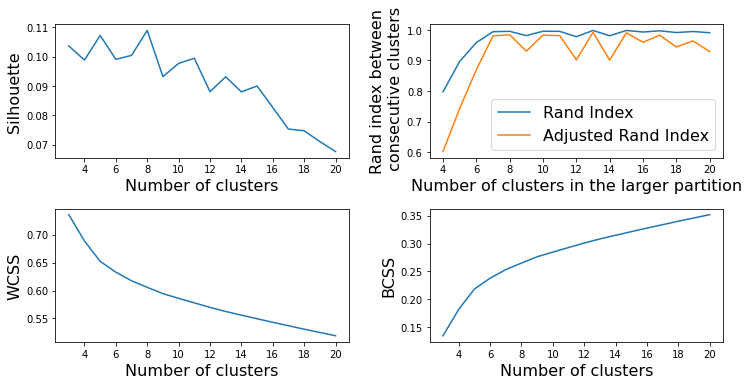

In [ ]:
nb = np.linspace(minim_cluster, maxim_cluster-1, num = maxim_cluster-minim_cluster)
fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.tight_layout(h_pad=3, w_pad = 5)
axs[0, 0].plot(nb, silh)
axs[0, 0].set_xlabel("Number of clusters", size = 16)
axs[0, 0].set_ylabel("Silhouette", size = 16)
axs[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[0, 1].plot(nb[1:], rand[:, 0], label="Rand Index")
axs[0, 1].plot(nb[1:], rand[:, 1], label="Adjusted Rand Index")
axs[0, 1].set_xlabel("Number of clusters in the larger partition", size = 16)
axs[0, 1].set_ylabel("Rand index between\n consecutive clusters", size = 16)
axs[0, 1].legend(fontsize = 16)

axs[1, 0].plot(nb, within_clusters)
axs[1, 0].set_xlabel("Number of clusters", size = 16)
axs[1, 0].set_ylabel("WCSS", size = 16)
axs[1, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1, 1].plot(nb, between_clusters)
axs[1, 1].set_xlabel("Number of clusters", size = 16)
axs[1, 1].set_ylabel("BCSS", size = 16)
axs[1, 1].xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.savefig('cluster_stats.pdf',bbox_inches='tight') 

## PCA

In [ ]:
pca = PCA(n_components=3)
pc = pca.fit_transform(normal)

In [ ]:
# 5 clusters
cluster5 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
clusters5 = cluster5.fit_predict(normal)
# 8 clusters
cluster8 = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')  
clusters8 = cluster8.fit_predict(normal)
# 10 clusters
cluster10 = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  
clusters10 = cluster10.fit_predict(normal)

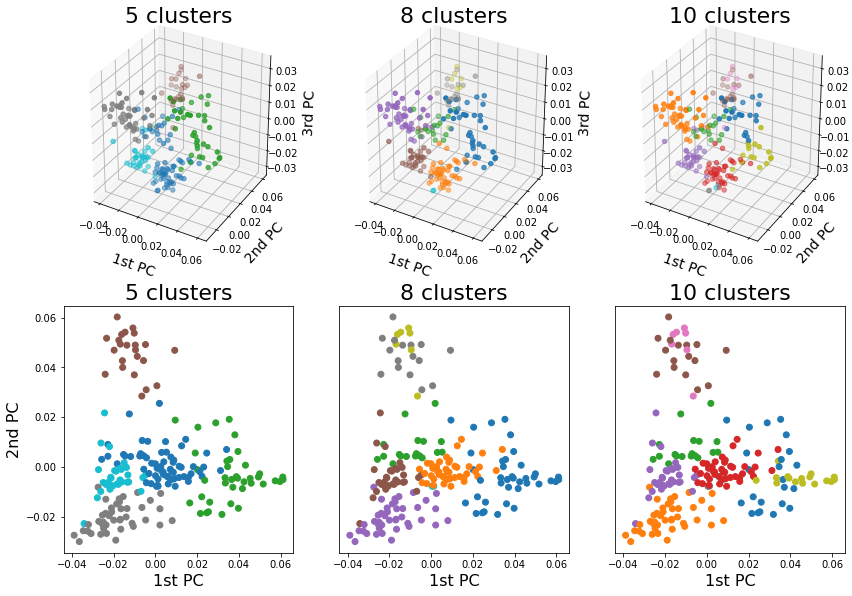

In [ ]:
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
ax1.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c = clusters5, cmap = "tab10")
ax1.set_xlabel("\n1st PC", size = 14, linespacing=1)
ax1.set_ylabel("\n2nd PC", size = 14, linespacing=1)
ax1.set_zlabel("\n3rd PC", size = 14, linespacing=1)
ax1.set_title("5 clusters", size = 22)

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c = clusters8, cmap = "tab10")
ax2.set_xlabel("\n1st PC", size = 14, linespacing=1)
ax2.set_ylabel("\n2nd PC", size = 14, linespacing=1)
ax2.set_zlabel("\n3rd PC", size = 14, linespacing=1)
ax2.set_title("8 clusters", size = 22)

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c = clusters10, cmap = "tab10")
ax3.set_xlabel("\n1st PC", size = 14, linespacing=1)
ax3.set_ylabel("\n2nd PC", size = 14, linespacing=1)
ax3.set_zlabel("\n3rd PC", size = 14, linespacing=1)
ax3.set_title("10 clusters", size = 22)

ax4 = fig.add_subplot(2, 3, 4)
ax4.scatter(pc[:, 0], pc[:, 1], c = clusters5, cmap = "tab10")
ax4.set_xlabel("1st PC", size = 16)
ax4.set_ylabel("2nd PC", size = 16)
ax4.set_title("5 clusters", size = 22)

ax5 = fig.add_subplot(2, 3, 5, sharey=ax4)
ax5.scatter(pc[:, 0], pc[:, 1], c = clusters8, cmap = "tab10")
ax5.set_xlabel("1st PC", size = 16)
ax5.set_title("8 clusters", size = 22)
ax5.get_yaxis().set_visible(False)

ax6 = fig.add_subplot(2, 3, 6, sharey=ax4)
ax6.scatter(pc[:, 0], pc[:, 1], c = clusters10, cmap = "tab10")
ax6.set_xlabel("1st PC", size = 16)
ax6.set_title("10 clusters", size = 22)
ax6.get_yaxis().set_visible(False)

plt.savefig('pc.pdf', bbox_inches='tight') 

# Cluster summary

In [ ]:
# Set number of clusters
nb_clusters = 8

# Cluster
normal = normalize(sims_google)
cluster = AgglomerativeClustering(n_clusters=nb_clusters, affinity='euclidean', linkage='ward')  
clusters = cluster.fit_predict(normal)

In [ ]:
# Most representative sentence function
most_representative = np.zeros(nb_clusters, dtype=np.int8)

for i in range(nb_clusters):
  # Subset all datapoints in cluster
    sbst = normal[clusters == i]
    # Centroid
    col_mean = np.mean(sbst, axis = 0)
    # Closest to centroid
    minim = np.argmin(np.sum((sbst - col_mean)**2, axis = 1))
    most_representative[i] = minim

In [ ]:
# Average sentence length in characters
def aver_sent_len(x):
    sum_sents = 0
    for sent in x:
        sum_sents += len(sent)

    return round((sum_sents / len(x)), 1)

# Return most frequent words in dataset
def com_words(x):
    common = collections.Counter(' '.join(x).split()).most_common(5)
    return(", ".join([word for word, word_count in common]))

In [ ]:
# Indeces for clusters
indx = ["Cluster" + str(i+1) for i in range(nb_clusters)]
dt_clust = pd.DataFrame({}, index = indx )

# Create a summary dataframe for clusters
all_lines = np.zeros((nb_clusters, len(dt.Topic.unique())))
for i in range(nb_clusters):
    sbst = dt.iloc[np.where(clusters == i)[0],:]
    all_lines[i] = sbst.Topic.value_counts().reindex(dt.Topic.unique(), fill_value=0).tolist()

for i in range(len(dt.Topic.unique())):
    dt_clust[dt.Topic.unique()[i]] = all_lines[:, i]

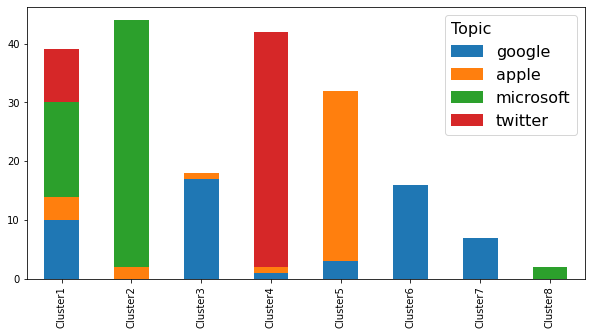

In [ ]:
# Plot of clusters by topic
dt_clust.plot(kind='bar', stacked=True,figsize=(10, 5))
leg = plt.legend(fontsize=16, title = "Topic", title_fontsize=16)
leg._legend_box.align = "left"
# plt.savefig('topic.pdf',bbox_inches='tight') 

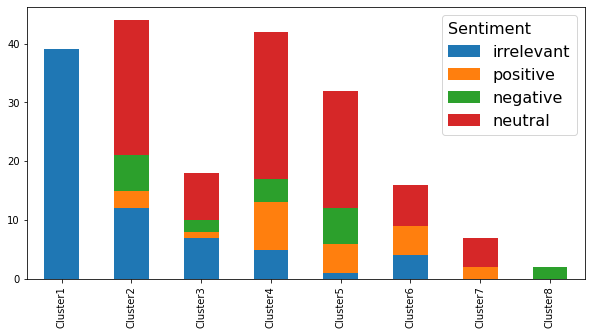

In [ ]:
# Plot of clusters by sentiment
dt_sent = pd.DataFrame({}, index = indx )
all_lines = np.zeros((nb_clusters, len(dt.Sentiment.unique())))
for i in range(nb_clusters):
    sbst = dt.iloc[np.where(clusters == i)[0],:]
    all_lines[i] = sbst.Sentiment.value_counts().reindex(dt.Sentiment.unique(), fill_value=0).tolist()
    
for i in range(len(dt.Sentiment.unique())):
    dt_sent[dt.Sentiment.unique()[i]] = all_lines[:, i]
dt_sent.plot(kind='bar', stacked=True,figsize=(10, 5))
leg = plt.legend(fontsize=16, title = "Sentiment", title_fontsize=16)
leg._legend_box.align = "left"
# plt.savefig('sentiment.pdf',bbox_inches='tight') 

In [ ]:
# Summary statistics for each cluster
for i in range(8):
  cluster = dt.iloc[np.where(clusters == i)[0],:]
  print("The most representative sentence in cluster", str(i+1), ":",
        dt.iloc[np.where(clusters == i)[0],:].iloc[most_representative[i]].sent)
  print("Average sentence length for cluster", str(i+1), ":", 
        aver_sent_len(cluster.sent))
  print("The 5 most common words in cluster", str(i+1), "are:", com_words(cluster["sent_punct"]))

The most representative sentence in cluster 1 : #Facebook prepara una aplicación para controlar el consumo de energía http://t.co/ritcdsD2 #Google y #Microsoft dejaron proyectos similares.
Average sentence length for cluster 1 : 107.5
The 5 most common words in cluster 1 are: microsoft, de, rt, el, google
The most representative sentence in cluster 2 : Nokia employees still worried that Elop is a Microsoft mole http://t.co/n4Cpu3vj #microsoft #windows
Average sentence length for cluster 2 : 110.4
The 5 most common words in cluster 2 are: microsoft, rt, new, windows, one
The most representative sentence in cluster 3 : But does request desktop site work with hulu?!?!? #ICS #Google
Average sentence length for cluster 3 : 99.1
The 5 most common words in cluster 3 are: google, asia, seo, ics, marketing
The most representative sentence in cluster 4 : #facebook, #Twitter , #spongebob, #nirvana. Great way to spend the night. :D
Average sentence length for cluster 4 : 79.0
The 5 most common wor

## Investigating each cluster individually

In [ ]:
cluster0 = dt.iloc[np.where(clusters == 0)[0],:]
with pd.option_context('display.max_rows', None,'display.max_columns', None, 'display.width', None, 'display.max_colwidth', -1):
  print(cluster0.sent)

3      RT “@microsoftfrance: Cette année encore, #Microsoft remporte le prix du meilleur Service Client 2012 http://t.co/fMRd5g3s”                 
15     RT @twandroid Nouvelle application Contacts : les connections Linkedin, Twitter.. sont enfin intégrées ! #google #nexusprime                
36     definitivamente sigo sin entender un carajo de #Google+                                                                                     
41     #Microsoft y el nuevo #Omnitouch, convierte cualquier superficie en pantalla tactil, http://t.co/TkgcW6y8                                   
42     Steve Balmer a beau être complètement barge, il a parfois des discours qui font mouche. Ici, sur le #Cloud : http://t.co/AHM1vZUg #Microsoft
45     RT @JuanJimenez_V: Tan linda #MiN' me arreglo el #Twitter de nuevoooo!! ♥                                                                   
46     Steve Ballmer haalt uit naar #Android http://t.co/LlIxBzeV #nuandroid Dan ben ik ook een nerd, ja daaaaag

In [ ]:
with pd.option_context('display.max_rows', None, 'display.width', None, 'display.max_colwidth', -1):
  print(dt.iloc[np.where(clusters == 1)[0],0:3])

         Topic   Sentiment  \
8    microsoft  negative     
16   microsoft  negative     
17   microsoft  negative     
18   microsoft  neutral      
19   microsoft  neutral      
20   microsoft  irrelevant   
23   microsoft  neutral      
29   microsoft  irrelevant   
32   apple      neutral      
34   microsoft  irrelevant   
43   microsoft  neutral      
44   microsoft  irrelevant   
48   microsoft  neutral      
49   apple      neutral      
54   microsoft  neutral      
57   microsoft  neutral      
63   microsoft  irrelevant   
64   microsoft  neutral      
78   microsoft  positive     
81   microsoft  irrelevant   
84   microsoft  neutral      
98   microsoft  neutral      
101  microsoft  neutral      
103  microsoft  irrelevant   
113  microsoft  irrelevant   
122  microsoft  positive     
133  microsoft  negative     
136  microsoft  neutral      
142  microsoft  neutral      
144  microsoft  negative     
146  microsoft  neutral      
150  microsoft  negative     
151  micro

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1):
  print(dt.iloc[np.where(clusters == 2)[0],0:3])

      Topic   Sentiment  \
0    google  irrelevant   
22   google  negative     
26   apple   neutral      
30   google  irrelevant   
33   google  neutral      
86   google  irrelevant   
90   google  irrelevant   
91   google  irrelevant   
99   google  neutral      
104  google  neutral      
125  google  irrelevant   
128  google  neutral      
155  google  neutral      
163  google  irrelevant   
171  google  neutral      
177  google  negative     
178  google  neutral      
189  google  positive     

                                                                                                                                             sent  
0    AsiaClassifiedToday Asia Family Offices to Triple, Lead Growth, Citigroup Says - BusinessWeek... http://t.co/93f16E44 #asia #google #biz      
22   RT @RoycinD: Face Unlock ! #ICS Literally knows your face! #Google #galaxynexus FAILED !                                                      
26   The 'Great Tech War': @Apple, @Facebo

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1):
  print(dt.iloc[np.where(clusters == 3)[0],2])

11     #Google (and #Twitter ) get ready for the debut of #IceCreamSandwich http://t.co/T36KZ6gf                                                   
12     RT @Lecko_alx: My #twitter age is 2 years 94 days 1 hour 40 minutes 33 seconds. Find out yours at http://t.co/spItzFcx #twittertime         
21     Good night #Twitter Off(:                                                                                                                   
25     Quit acting all hard. It's only #twitter                                                                                                    
27     #Twitter are you freaking kidding me #wth... http://t.co/zKn2bu5R                                                                           
31     Shout out to all the single mothers on #Twitter                                                                                             
35     #twitter is jumpin as usual :)                                                                           

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1):
  print(dt.iloc[np.where(clusters == 4)[0],2])

1      @apple Siri is amazing                                                                                                                      
4      Gotta say the @Apple itouch iphone shuffle etc.. sound quality is AWFUL.. painfully crap. Its been a downgrade from @Sony sound quality wise
5      @Apple's Steve Jobs Gets His Day | PCWorld http://t.co/6gT6w2Od                                                                             
13     I just realized that the reason I got into twitter was ios5 thanks @apple                                                                   
14     how come when #google talks about their #android camera app it's boring, but when #apple does it's ZOMG!!!1                                 
24     We did an unexpected workshop for the #iPhone4S at @apple yesterday and we got an awesome amount of info #notjustaboutthephone @gamerchik16 
28     @apple can you get your iphone to stop vibrating when you get a text?                                    

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1):
  print(dt.iloc[np.where(clusters == 5)[0],2])

2      #GOOGLE #ANDROID 4.0 out ;-) Available with #SAMSUNG nexus!                                                                                      
6      Three UK to carry Samsung Galaxy Nexus http://t.co/SwvAcbxC  #android #google                                                                    
55     Samsung Galaxy Nexus & Android 4.0 Quick Specs - http://t.co/s1QfUznv #galaxynexus #android #ics #samsung #google                                
79     New Galaxy Nexus: App Improvements -  New visual voicemail within the phone app #nexus #samsung #google #android bit.ly/nEJbyE                   
80     #Google Ice Cream Sandwich, Nexus Prime Launch [LIVE BLOG] http://t.co/YD4FBog3 #uncategorized #android                                          
87     #Android #Google Galaxy Nexus Site is Live: Register and Relive the New Features http://t.co/7llRSpUO #DhilipSiva                                
102    New Galaxy Nexus: App Improvements -  Inbuilt Panoramic Pictures #nexus #sa

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1):
  print(dt.iloc[np.where(clusters == 6)[0],2])

9      Mmmm Ice Cream Sandwich #Android #Google                                                                                                    
38     Installing the Ice Cream Sandwich SDK #android #google                                                                                      
62     RT @YashasJoshi: #android 4.0!!  Ice Cream Sandwich will now make all other smartphone operating systems look outdated.  #Androidbeam Wo ...
106    #Android #Google Android 4.0 Ice Cream Sandwich Official, SDK Now Available http://t.co/rXuPIW2U #DhilipSiva                                
124    Google officially announces Ice Cream Sandwich http://t.co/u702sosO  #android #google                                                       
132    Ice Cream Sandwich Android: #IceCreamSandwichAndroid  #Ice #Cream #Sandwich #Android http://t.co/pVRaHhxR #google #youtube                  
152    RT @aalkhubaizi: Introducing Android 4.0, Ice Cream SandwichIntroducing Android 4.0, Ice Cream Sandwich h

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1):
  print(dt.iloc[np.where(clusters == 7)[0],2])

7     Reader 'Tronman' compares #SteveBallmer to an albatross around #Microsoft's neck.  Do you agree?  Join the discussion! http://t.co/DFFkvnSJ
10    Reader 'Tronman' compares #SteveBallmer to an albatross around #Microsoft's neck.  Do you agree?  Join the discussion! http://t.co/2iJK0VB3
Name: sent, dtype: object


In [ ]:
    sum_sents = 0
    for sent in x:
        sum_sents += len(sent)

    return round((sum_sents / len(x)), 3)

In [ ]:
aver_sent_len(cluster0.sent)

107.513